# Comparison of GLIF models for my implementation and that in Teeter et al. (2018)


## Generate Neural Response for Teeter et al. (2018) - Figure 1b

In [21]:
import numpy as np
import pickle
import os
import allensdk.core.json_utilities as ju
from allensdk.model.glif.glif_neuron import GlifNeuron
import sys
import time
import matplotlib.pyplot as plt

relative_path=os.path.dirname('/home/williamsnider/Code/GLIF_Teeter_et_al_2018/create_data_dir')
sys.path.append(os.path.join(relative_path, 'libraries'))
from data_library import get_file_path_endswith, get_sweep_num_by_name
from allensdk.core.cell_types_cache import CellTypesCache
ctc = CellTypesCache(manifest_file=os.path.join(relative_path,'cell_types_manifest.json'))

#---------------------------------------------------------------
#------------NO SPECIFICATIONS NEEDED---------------------------
#---------------------------------------------------------------

def get_model(path, EW):
    '''Runs the model for a specified neuron and model
    inputs:
        path: string
            folder path with files for the neuron
        EW: string
            end of file searching for:  options '_GLIF1_neuron_config.json',_GLIF2_neuron_config.json' etc.
    returns:
        run_data: dictionary
            contains data from the model run
            
   '''

    specimen_id=int(os.path.basename(path)[:9])
    file=get_file_path_endswith(path, EW)

    # load data
    dir_name=os.path.join(relative_path, 'mouse_nwb/specimen_'+ str(specimen_id))
    all_sweeps=ctc.get_ephys_sweeps(specimen_id,  os.path.join(dir_name, 'ephys_sweeps.json'))
    #all_sweeps=ctc.get_ephys_sweeps(specimen_id)
    sweeps=get_sweep_num_by_name(all_sweeps, 'Noise 2')
    
    noise2_sweeps = get_sweep_num_by_name(all_sweeps, 'Noise 2')
#    noise2_data=ctc.get_ephys_data(specimen_id).get_sweep(noise2_sweeps[0])
    noise2_data=ctc.get_ephys_data(specimen_id, os.path.join(dir_name, 'ephys.nwb')).get_sweep(noise2_sweeps[0])

    # run model with current
    stimulus2=noise2_data['stimulus']
    neuron_config=ju.read(file)
    neuron_config['dt']=1./noise2_data['sampling_rate'] #reset dt to the stimulus dt not the optimization dt
    neuron = GlifNeuron.from_dict(neuron_config)
    1/noise2_data['sampling_rate']
    run_data = neuron.run(stimulus2)
    run_data['time']=np.arange(0, len(run_data['voltage']))*neuron_config['dt']
    run_data['El_reference']=neuron_config['El_reference']    
    run_data['stimulus']=noise2_data['stimulus']

    return run_data

def make_and_save_models(specimen_id):
    '''Runs models and creates resulting voltage waveforms and saves them to a pickle file
    inputs:
        specimen_id: integer
            specifies neuron to be run
    outputs:
        pickle files
    '''
    
    global start_time #grab start_time from outside this module
    
    # finding the folder associated with the desired specimen_id 
    for dir in folders:
        sp_id=int(os.path.basename(dir)[:9])
        if sp_id == specimen_id:
            folder=dir
    cre=os.path.basename(folder)[10:]
    
    try:
        os.makedirs('pkl_data')
    except: pass
    
    print('running LIF')
    LIF_model=get_model(folder, '_GLIF1_neuron_config.json')
    pickle.dump(LIF_model, open("pkl_data/"+str(specimen_id)+cre+"_LIF_model.pkl", "wb" ))
    print('GLIF1 done at',(time.time()-start_time)/60., 'min')

    # print('running LIFR')
    # LIFR_model=get_model(folder, '_GLIF2_neuron_config.json')
    # pickle.dump(LIFR_model, open("pkl_data/"+str(specimen_id)+cre+"_LIFR_model.pkl", "wb" ))
    # print('GLIF2 done at',(time.time()-start_time)/60., 'min')

    # print('running LIFASC')
    # LIFASC_model=get_model(folder, '_GLIF3_neuron_config.json')
    # pickle.dump(LIFASC_model, open("pkl_data/"+str(specimen_id)+cre+"_LIFASC_model.pkl", "wb" ))
    # print('GLIF3 done at',(time.time()-start_time)/60., 'min')

    # print('running LIFRASC')
    # LIFRASC_model=get_model(folder, '_GLIF4_neuron_config.json')
    # pickle.dump(LIFRASC_model, open("pkl_data/"+str(specimen_id)+cre+"_LIFRASC_model.pkl", "wb" ))
    # print('GLIF4 done at',(time.time()-start_time)/60., 'min')
    
    # print('running LIFRASCAT')
    # LIFRASCAT_model=get_model(folder, '_GLIF5_neuron_config.json')
    # pickle.dump(LIFRASCAT_model, open("pkl_data/"+str(specimen_id)+cre+"_LIFRASCAT_model.pkl", "wb" ))
    # print('GLIF5 done at',(time.time()-start_time)/60., 'min')


path=os.path.join(relative_path,'mouse_struc_data_dir')
folders=[os.path.join(path, f) for f in  os.listdir(path)]

start_time=time.time()

#--make and save models
specimen_id=474637203
# make_and_save_models(specimen_id)

# specimen_id=512322162
# make_and_save_models(specimen_id)

# specimen_id=512322162

# finding the folder associated with the desired specimen_id 
import matplotlib.pyplot as plt
for dir in folders:
    sp_id=int(os.path.basename(dir)[:9])
    if sp_id == specimen_id:
        folder=dir
cre=os.path.basename(folder)[10:]

try:
    os.makedirs('pkl_data')
except: pass

print('running LIF')
LIF_model=get_model(folder, '_GLIF1_neuron_config.json')
pickle.dump(LIF_model, open("pkl_data/"+str(specimen_id)+cre+"_LIF_model.pkl", "wb" ))
print('GLIF1 done at',(time.time()-start_time)/60., 'min')

# print('running LIFR')
# LIFR_model=get_model(folder, '_GLIF2_neuron_config.json')
# pickle.dump(LIFR_model, open("pkl_data/"+str(specimen_id)+cre+"_LIFR_model.pkl", "wb" ))
# print('GLIF2 done at',(time.time()-start_time)/60., 'min')

# print('running LIFASC')
# LIFASC_model=get_model(folder, '_GLIF3_neuron_config.json')
# pickle.dump(LIFASC_model, open("pkl_data/"+str(specimen_id)+cre+"_LIFASC_model.pkl", "wb" ))
# print('GLIF3 done at',(time.time()-start_time)/60., 'min')

# print('running LIFRASC')
# LIFRASC_model=get_model(folder, '_GLIF4_neuron_config.json')
# pickle.dump(LIFRASC_model, open("pkl_data/"+str(specimen_id)+cre+"_LIFRASC_model.pkl", "wb" ))
# print('GLIF4 done at',(time.time()-start_time)/60., 'min')

# print('running LIFRASCAT')
# LIFRASCAT_model=get_model(folder, '_GLIF5_neuron_config.json')
# pickle.dump(LIFRASCAT_model, open("pkl_data/"+str(specimen_id)+cre+"_LIFRASCAT_model.pkl", "wb" ))
# print('GLIF5 done at',(time.time()-start_time)/60., 'min')



running LIF
GLIF1 done at 0.8141137997309367 min


## Key variables are Voltage and Stimulus (external input current)

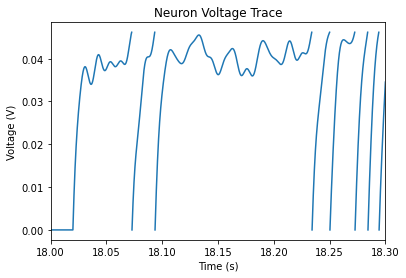

In [22]:
V = LIF_model['voltage']
t = LIF_model['time']
S = LIF_model['stimulus']

fig, ax = plt.subplots()
ax.plot(t, V)
ax.set_xlim(18,18.3)
ax.set_ylabel('Voltage (V)')
ax.set_xlabel('Time (s)')
ax.set_title('Neuron Voltage Trace')
plt.show()

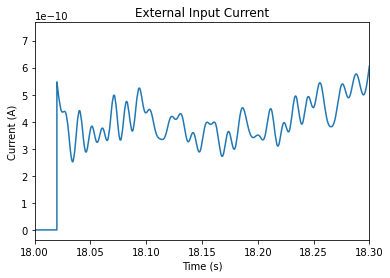

In [23]:
fig, ax = plt.subplots()
ax.plot(t, S)
ax.set_xlim(18,18.3)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Current (A)')  # Check unit
ax.set_title('External Input Current')
plt.show()

## Apply same external input current to my GLIF 

In [27]:
from GLIF_models import GLIF_1
from pygenn.genn_model import GeNNModel, create_custom_current_source_class, create_custom_neuron_class
from pygenn.genn_groups import CurrentSource
import matplotlib.pyplot as plt

GLIF_1 = create_custom_neuron_class(
    "GLIF_1",
    param_names = ["C", "G", "El","Ie", "V_thres"],
    var_name_types=[("V", "scalar")],
    sim_code='$(V)+=1/$(C)*($(Ie)-$(G)*($(V)-$(El)));',
    threshold_condition_code='$(V)>=$(V_thres)',
    reset_code = '$(V)=$(El);'
)


### Add GLIF Class to model ###
# TODO: copy parameters from Teeter 2018 config file
GLIF_1_params = {"C": 60.72,
              "G": 1.0,
              "El": -79.04,
              "Ie": 0.0,  # TODO: this is a placeholder until I learn how to add external input current
              "V_thres": -49.63}
GLIF_1_init = {"V": -65.0}
num_GLIF = 1
model = GeNNModel("float", "GLIF_1")
model.dT=0.1
pop1 = model.add_neuron_population(
    pop_name = "pop1",
    num_neurons = num_GLIF,
    neuron = GLIF_1,
    param_space = GLIF_1_params,
    var_space = GLIF_1_init,
)


# Need to add a synapse to declare Isyn?
s_ini = {"g": 0}
ps_p = {"tau": 1.0, # Decay time constant [ms] 
        "E": -80.0} # Reversal potential [mV]
model.add_synapse_population("Pop1self", "SPARSE_GLOBALG", 1,
    pop1, pop1,
    "StaticPulse", {}, s_ini, {}, {},
    "ExpCond", ps_p, {},)


### Add current source to model ###
external_current_source = create_custom_current_source_class(
    class_name = "external_current",
    var_name_types = [("step", "unsigned int"), ("current_array", "double") ],  # How to index array?
    injection_code = """
    $(injectCurrent, $(current_array)[$(step)]);
    $(step)++;
    """,
)
cs_ini = {"step": 0, "current_array": S}  # external input current from Teeter 2018
model.add_current_source(
    cs_name = "external_current_source", 
    current_source_model=external_current_source,
    pop = pop1,
    param_space = {},
    var_space = cs_ini)


model.build()
model.load()

# Run a quick simulation
v = np.empty((2000, num_GLIF))
v_view = pop1.vars["V"].view
while model.t < 200.0:
    model.step_time()
    pop1.pull_var_from_device("V")
    
    v[model.timestep - 1,:]=v_view[:]
    
# Plot the results -- voltage of the neuron for 200 timesteps
fig, axis = plt.subplots()
axis.plot(v[:2000,:])
axis.set_xlabel('Timesteps')
axis.set_ylabel('mV')
plt.show()

CalledProcessError: Command '['make', '-j', '8', '-C', './GLIF_1_CODE']' returned non-zero exit status 2.